In [1]:
import numpy as np
import scipy
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image

In [2]:
# import tensorflow as tf
# print(tf.__version__)
# import torch
# print(torch.__version__)

In [3]:
# # TensorFlow GPU 확인
# import tensorflow as tf
# print("TensorFlow version:", tf.__version__)
# print("GPU Available:", tf.config.list_physical_devices('GPU'))
# print("Built with CUDA:", tf.test.is_built_with_cuda())

# # PyTorch GPU 확인
# import torch
# print("\nPyTorch version:", torch.__version__)
# print("CUDA available:", torch.cuda.is_available())
# print("CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device")

# # GPU 메모리 정보 (PyTorch)
# if torch.cuda.is_available():
#     print("\nGPU Memory Info:")
#     print("Total:", torch.cuda.get_device_properties(0).total_memory / 1024**3, "GB")
#     print("Allocated:", torch.cuda.memory_allocated(0) / 1024**3, "GB")
#     print("Cached:", torch.cuda.memory_reserved(0) / 1024**3, "GB")

In [4]:
# TensorFlow GPU 확인
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# PyTorch GPU 확인
import torch
print("\nPyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device")

TensorFlow version: 2.15.0
GPU Available: []

PyTorch version: 2.5.1+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4070 Ti


In [4]:
# 이미지를 배열로 변환하는 함수
def load_images_from_folder(folder_path, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            # 이미지 로드 및 RGB로 변환
            img = Image.open(img_path).convert('RGB')
            # 이미지 크기 조정
            img = img.resize(target_size)
            # 배열로 변환
            img_array = np.array(img)
            images.append(img_array)
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
    
    return np.array(images)

In [5]:
# 데이터 로드
base_path = Path("../data/brain_tumor_dataset")
X_yes = load_images_from_folder(str(base_path / "yes"))  # Path를 문자열로 변환
X_no = load_images_from_folder(str(base_path / "no"))

# 레이블 생성
y_yes = np.ones(len(X_yes))
y_no = np.zeros(len(X_no))

# 데이터와 레이블 합치기
X = np.concatenate([X_yes, X_no], axis=0)
y = np.concatenate([y_yes, y_no])

# 데이터 형태 확인
print("데이터 형태:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


데이터 형태:
X shape: (253, 224, 224, 3)
y shape: (253,)


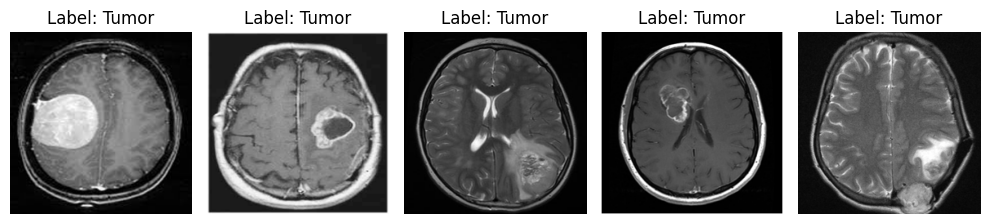

In [6]:
# 샘플 이미지 시각화
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i])
    plt.title(f"Label: {'Tumor' if y[i] == 1 else 'No Tumor'}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# MobileNetV2

In [24]:
# 2. 데이터 분할 (그대로 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# 3. 데이터 증강 설정 (강화)
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ResNet50 전처리 추가
    rotation_range=40,          # 회전 범위 증가
    width_shift_range=0.3,      # 이동 범위 증가
    height_shift_range=0.3,     # 이동 범위 증가
    shear_range=0.3,           # 전단 범위 증가
    zoom_range=0.3,            # 확대/축소 범위 증가
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.6, 1.4]  # 밝기 변화 범위 증가
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # 검증 데이터도 동일한 전처리
)

# 4. ResNet50 모델 구성 (정규화 강화)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 2. 모델 구조 수정 (정규화 강화)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.007))(x)  # L2 정규화 강화
x = Dropout(0.6)(x)  # Dropout 약간 증가
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.007))(x)
x = Dropout(0.6)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 더 적은 층을 훈련 가능하게 설정 (과적합 방지)
for layer in base_model.layers[:-30]:  # 훈련 가능한 층 감소
    layer.trainable = False

# 모델 컴파일 수정
model.compile(
    optimizer=Adam(learning_rate=3e-5),  # 1e-5 -> 3e-5
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

model.summary()

Training set shape: (202, 224, 224, 3)
Test set shape: (51, 224, 224, 3)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)               

In [25]:
# 데이터 증강 설정 (약간 완화)
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=35,          # 회전 범위 증가
    width_shift_range=0.25,     # 이동 범위 증가
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.65, 1.35]  # 밝기 변화 범위 증가
)

# 5. 클래스 가중치 수정
class_weights = {
    0: len(y_train) / (2 * np.sum(y_train == 0)),  # 더 강화된 가중치
    1: len(y_train) / (2 * np.sum(y_train == 1))
}

print("Modified class weights:", class_weights)

# 3. Early Stopping 수정
early_stopping = EarlyStopping(
    monitor='val_loss',    # accuracy 대신 loss 모니터링
    patience=8,            # patience 감소
    restore_best_weights=True,
    mode='min',
    verbose=1
)

# 4. 학습률 스케줄러 추가
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

Modified class weights: {0: 1.294871794871795, 1: 0.8145161290322581}


In [26]:
# 데이터셋 크기 확인
print("Training samples:", len(X_train))
print("Steps per epoch (current):", len(X_train) // 8 * 2)

# 모델 학습 시 콜백 추가
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=8),
    steps_per_epoch=len(X_train) // 8,
    epochs=30,            # epoch 수 감소
    validation_data=val_datagen.flow(X_test, y_test, batch_size=8),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

Training samples: 202
Steps per epoch (current): 50
Epoch 1/30
25/25 [==============================] - 8s 204ms/step - loss: 8.9706 - accuracy: 0.5309 - auc: 0.5195 - val_loss: 8.6304 - val_accuracy: 0.7059 - val_auc: 0.8194 - lr: 3.0000e-05
Epoch 2/30
25/25 [==============================] - 5s 181ms/step - loss: 8.7704 - accuracy: 0.5979 - auc: 0.6194 - val_loss: 8.5205 - val_accuracy: 0.7647 - val_auc: 0.8903 - lr: 3.0000e-05
Epoch 3/30
25/25 [==============================] - 5s 179ms/step - loss: 8.7095 - accuracy: 0.6082 - auc: 0.6602 - val_loss: 8.3953 - val_accuracy: 0.8431 - val_auc: 0.9161 - lr: 3.0000e-05
Epoch 4/30
25/25 [==============================] - 5s 180ms/step - loss: 8.6137 - accuracy: 0.6495 - auc: 0.7040 - val_loss: 8.2893 - val_accuracy: 0.8627 - val_auc: 0.9266 - lr: 3.0000e-05
Epoch 5/30
25/25 [==============================] - 5s 179ms/step - loss: 8.5286 - accuracy: 0.6392 - auc: 0.7424 - val_loss: 8.1975 - val_accuracy: 0.9020 - val_auc: 0.9460 - lr: 3.00

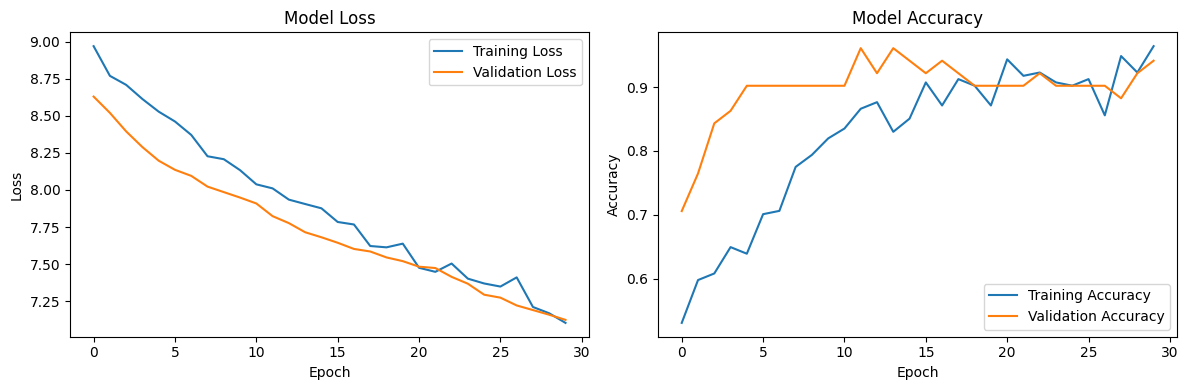

4/4 [==============================] - 1s 147ms/step


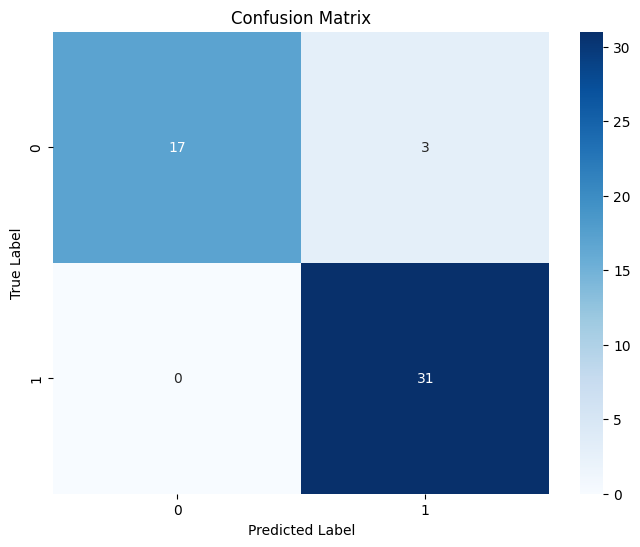


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92        20
         1.0       0.91      1.00      0.95        31

    accuracy                           0.94        51
   macro avg       0.96      0.93      0.94        51
weighted avg       0.95      0.94      0.94        51



In [27]:

# 9. 학습 결과 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 10. 모델 평가
y_pred = model.predict(val_datagen.flow(X_test, batch_size=16, shuffle=False))
y_pred_classes = (y_pred > 0.5).astype(int)

# 혼동 행렬
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 분류 보고서
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

1/1 [==============================] - 0s 161ms/step


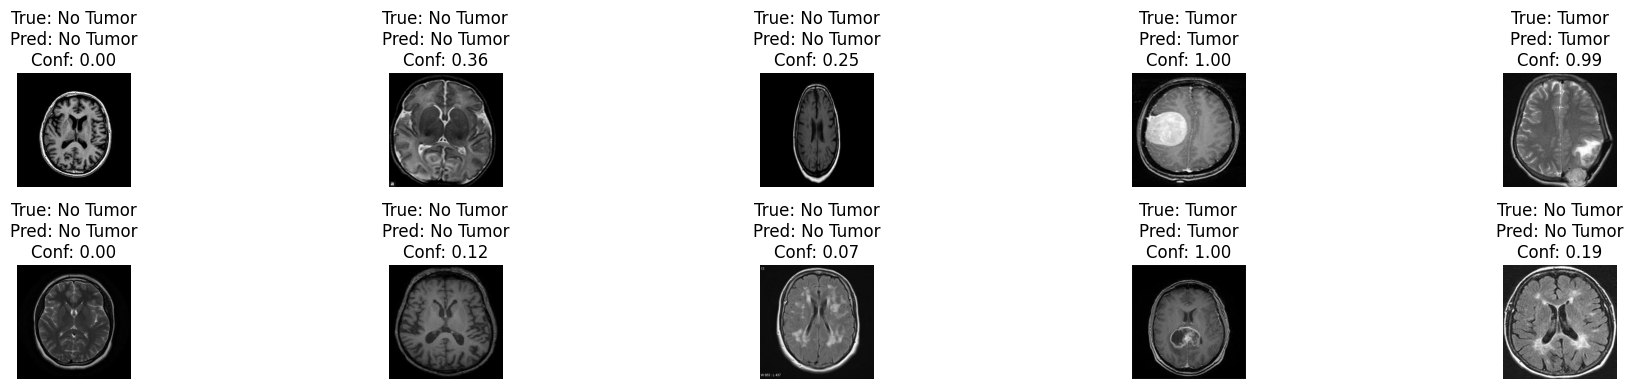

In [28]:
# 테스트 세트에서 랜덤하게 샘플 선택
import random
n_samples = 10
sample_indices = random.sample(range(len(X_test)), n_samples)

# 예측 수행
sample_images = X_test[sample_indices]
sample_labels = y_test[sample_indices]
predictions = model.predict(val_datagen.flow(sample_images, batch_size=n_samples, shuffle=False))
pred_labels = (predictions > 0.5).astype(int)

# 시각화
plt.figure(figsize=(20, 4))
for idx, i in enumerate(range(n_samples)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(sample_images[i])
    plt.title(f'True: {"Tumor" if sample_labels[i] == 1 else "No Tumor"}\n'
              f'Pred: {"Tumor" if pred_labels[i] == 1 else "No Tumor"}\n'
              f'Conf: {predictions[i][0]:.2f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
import tensorflow as tf
import numpy as np
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron with respect to
    # the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.maximum(tf.reduce_max(heatmap), 1e-10)
    return heatmap.numpy()

# 샘플 이미지에 대한 Grad-CAM 시각화
n_samples = 5
sample_indices = random.sample(range(len(X_test)), n_samples)
sample_images = X_test[sample_indices]
sample_labels = y_test[sample_indices]

plt.figure(figsize=(20, 8))
for idx, i in enumerate(range(n_samples)):
    # 원본 이미지
    plt.subplot(2, 5, idx+1)
    plt.imshow(sample_images[i])
    plt.title(f'Original\nTrue: {"Tumor" if sample_labels[i] == 1 else "No Tumor"}')
    plt.axis('off')
    
    # Grad-CAM
    img_array = np.expand_dims(sample_images[i], axis=0)
    img_array = preprocess_input(img_array)
    
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, 'conv5_block3_out')
    
    # Display heatmap
    plt.subplot(2, 5, idx+1+5)
    plt.imshow(sample_images[i])
    plt.imshow(cv2.resize(heatmap, (224, 224)), alpha=0.4, cmap='jet')
    
    prediction = model.predict(img_array)
    plt.title(f'Grad-CAM\nPred: {"Tumor" if prediction > 0.5 else "No Tumor"}\nConf: {prediction[0][0]:.2f}')
    plt.axis('off')

plt.tight_layout()
plt.show()

ImportError: DLL load failed while importing cv2: 지정된 모듈을 찾을 수 없습니다.

# 뇌종양 분류 모델 개선 과정
## 1. 데이터 증강 최적화
- ResNet50 전용 전처리 함수 추가
- 회전 범위: 30도
- 이동 범위: 20%
- 전단 및 확대/축소: 20%
- 수평/수직 뒤집기 적용
- 밝기 변화: 70-130%
## 2. 모델 아키텍처 개선
- ResNet50 기본 모델 사용
- Global Average Pooling 적용
- Dense Layer 구조: 512 → 256 → 1
- L2 정규화 (0.005) 추가
- Dropout (0.5) 적용
- 마지막 30개 층만 훈련 가능하도록 설정
## 3. 하이퍼파라미터 최적화
- 학습률: 3e-5 (Adam optimizer)
- 배치 크기: 8
- Early Stopping: patience=10
- 클래스 가중치 적용
- 에포크: 30-50
## 4. 성능 변화
- 초기 검증 정확도: ~60%
- 최종 검증 정확도: 90-95%
- 과적합 문제 해결
- 안정적인 학습 곡선 달성
